전처리 과정 
apg 데이터를 200초 단위까지 끊어서 MinMaxScaler를 이용해 정규화 시켜줌 그 후 con1v 모델의 input 값에 맞게 변형시켜줌

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

directory1 = "apg파일/"
data = []

# 데이터 전처리
for root, dirs, files in os.walk(directory1):
    for file in files:
        if file.endswith(".csv"):
            full_path = os.path.join(root, file)
            df = pd.read_csv(full_path, usecols=['APG Wave'])

            # 데이터 길이 고정
            series = df.values.flatten()
            if len(series) < 200:
                series = np.pad(series, (0, 200 - len(series)), mode='constant')
            else:
                series = series[:200]

            # MinMaxScaler 적용
            series = series.reshape(-1, 1)  # (200, 1)
            scaler = MinMaxScaler()
            series = scaler.fit_transform(series)
            data.append(series.flatten())  # (200,) 형태로 저장

# 배열로 변환
data_array = np.array(data)  # (num_files, 200)

print("Shape of data_array:", data_array.shape)  # 예상: (num_files, 200)


Shape of data_array: (130, 200)


apg데이터의 y_label값을 불러오는 코드입니다.

In [2]:
import pandas as pd

# 엑셀 파일 불러오기 (엑셀 파일의 경로를 넣어야 합니다)
df = pd.read_csv("2024-10-11 (11-00-32)-APG【 이기장 】.csv")
df_sorted = df.sort_values(by='TestDate')

# 정렬된 데이터프레임을 확인
# VasType 열의 모든 값에 3을 곱하기
df_sorted['VasType'] = df_sorted['VasType'] * 3
pd.set_option('display.max_rows', None)
# 결과 확인
import pandas as pd

# 조건에 따른 VasType 값 조정 함수 정의
def adjust_vastype(row):
    if row['TypeLebel'] == '+++':
        return row['VasType'] - 3
    elif row['TypeLebel'] == '++':
        return row['VasType'] - 2
    elif row['TypeLebel'] == '+':
        return row['VasType'] - 1
    else:
        return row['VasType']  # 조건에 맞지 않으면 변경하지 않음

# apply 함수로 각 행에 대해 VasType 값을 조정
df_sorted['VasType'] = df_sorted.apply(adjust_vastype, axis=1)

# 결과 확인
pd.set_option('display.max_rows', None)
df_sorted['VasType'].reset_index(drop=True,inplace=True)
df_sorted['VasType'].value_counts()
y = df_sorted['VasType'].values
# y = np.tile(df_sorted['VasType'].values, 5)




---

# APG 데이터 증강 기법

APG 데이터의 수가 부족하여 **증강 기법**을 이용해 데이터를 늘렸습니다.

---

## **증강 조합의 구성**

1. **노이즈 추가 (Gaussian Noise)**  
   - 다양한 `noise_std` 값으로 여러 데이터를 생성 가능.  
     - 예: `noise_std = [0.01, 0.02, 0.03]` → 3가지 변형  

2. **시간 왜곡 (Time-Warping)**  
   - 시간 축 왜곡 강도(`sigma`)를 다르게 설정하여 데이터 생성 가능.  
     - 예: `sigma = [0.1, 0.2, 0.3]` → 3가지 변형  

3. **진폭 왜곡 (Magnitude-Warping)**  
   - 진폭 변형 강도(`factor`)를 다르게 설정하여 데이터 생성 가능.  
     - 예: `factor = [0.1, 0.2, 0.3]` → 3가지 변형  

---

## **증강 조합의 계산**

각 증강 기법은 **독립적으로 적용**될 수 있으며, 동시에 **조합**될 수도 있습니다.  
조합의 총 개수는 다음과 같이 계산합니다:

\[
\{총 조합 수} = (\{노이즈 변형 개수}) * (\{시간 왜곡 변형 개수}) * (\{진폭 왜곡 변형 개수})
\]

### **예시 계산**  
- 노이즈 변형 개수: **3**  
- 시간 왜곡 변형 개수: **3**  
- 진폭 왜곡 변형 개수: **3**  

\[
3 (\{노이즈}) * 3 (\{시간 왜곡}) * 3 (\{진폭 왜곡}) = 27 \{ 조합}
\]

---

## **총 생성 가능한 데이터 수**

- **원본 데이터 개수**: 130개  
- **증강 조합 수**: 27개  

\[
\{총 데이터 수} = 130 (\{원본 데이터}) * 27 (\{증강 조합}) = 3510 \{ 개}
\]

---

### **요약**

- **원본 데이터 개수**: 130개  
- **총 조합 수**: 27개  
- **증강 후 데이터 총 개수**: **3510개**

---


In [5]:
import numpy as np

# 증강 함수 정의
def add_gaussian_noise(data, noise_std):
    noise = np.random.normal(0, noise_std, data.shape)
    return data + noise

def time_warp(data, sigma):
    time_stretch = np.linspace(0, 1, len(data))
    random_noise = np.random.normal(1.0, sigma, len(data))
    warped_time = np.cumsum(random_noise) / np.sum(random_noise)
    interpolated = np.interp(np.linspace(0, 1, len(data)), warped_time, data)
    return interpolated

def magnitude_warp(data, factor):
    magnitude_variation = 1 + np.random.uniform(-factor, factor, size=data.shape)
    return data * magnitude_variation

def augment_data_with_labels(data, labels, noise_levels, time_sigmas, magnitude_factors):
    augmented_data = []
    augmented_labels = []
    for i, sample in enumerate(data):
        label = labels[i]  # 해당 샘플의 라벨
        for noise in noise_levels:
            for sigma in time_sigmas:
                for factor in magnitude_factors:
                    noisy_data = add_gaussian_noise(sample, noise)
                    warped_time_data = time_warp(noisy_data, sigma)
                    warped_magnitude_data = magnitude_warp(warped_time_data, factor)
                    augmented_data.append(warped_magnitude_data)
                    augmented_labels.append(label)  # 라벨은 원본과 동일하게 추가
    return np.array(augmented_data), np.array(augmented_labels)

# 원본 데이터와 라벨
original_data = data_array
original_labels = y

# 증강 설정
noise_levels = [0.01, 0.02, 0.03]
time_sigmas = [0.1, 0.2, 0.3]
magnitude_factors = [0.1, 0.2, 0.3]

# 증강 수행
augmented_data, augmented_labels = augment_data_with_labels(
    original_data, original_labels, noise_levels, time_sigmas, magnitude_factors
)

# 결과 확인
print(f"원본 데이터 개수: {len(original_data)}")
print(f"증강된 데이터 개수: {len(augmented_data)}")
print(f"증강된 라벨 개수: {len(augmented_labels)}")

# 샘플 출력
print("증강된 데이터 샘플:", augmented_data[0])
print("증강된 데이터 라벨:", augmented_labels[0])


원본 데이터 개수: 130
증강된 데이터 개수: 3510
증강된 라벨 개수: 3510
증강된 데이터 샘플: [0.49785294 0.47332908 0.52144169 0.51052995 0.46375154 0.53193909
 0.46966567 0.51228416 0.49228854 0.51782748 0.47303398 0.54560226
 0.5037955  0.55577173 0.49294372 0.44821056 0.48240185 0.51260829
 0.44687299 0.52352975 0.51335665 0.55880261 0.51620505 0.60706692
 0.56898288 0.51960695 0.47565499 0.53778025 0.55302487 0.51947264
 0.51970328 0.45976999 0.45979223 0.47798436 0.46458117 0.45088411
 0.50025491 0.45109282 0.5242207  0.47806937 0.54687917 0.52491101
 0.6170196  0.67646812 0.78985834 0.81089254 0.9456281  0.87768244
 0.93862714 0.74261703 0.53748825 0.33286208 0.19374213 0.0622754
 0.00611006 0.00536247 0.05766127 0.14790102 0.29159801 0.42500366
 0.48826288 0.59274969 0.58737918 0.6503124  0.57993999 0.54765081
 0.57668853 0.549241   0.48557854 0.47862481 0.460117   0.47953263
 0.51499801 0.52851278 0.57757576 0.56632327 0.59647909 0.52637076
 0.51029101 0.50819228 0.45526606 0.41527862 0.45702052 0.47107257
 0.

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization,Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [9]:

augmented_data =augmented_data .reshape(augmented_data.shape[0], -1)  # (650, 200 * 1) 형태로 변환

X_train, X_val, y_train, y_val = train_test_split(augmented_data, augmented_labels , test_size=0.2, random_state=42)
s

Fold 1/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2240 - loss: 11.8661 - val_accuracy: 0.3950 - val_loss: 3.2349 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5076 - loss: 2.4087 - val_accuracy: 0.6477 - val_loss: 1.4135 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6096 - loss: 1.1234 - val_accuracy: 0.7295 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6128 - loss: 1.0965 - val_accuracy: 0.7242 - val_loss: 0.9502 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6875 - loss: 0.8500 - val_accuracy: 0.8167 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7058 - loss: 0.8608 - val_accuracy: 0.7278 - val_loss: 1.0319 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7057 - loss: 0.8347 - val

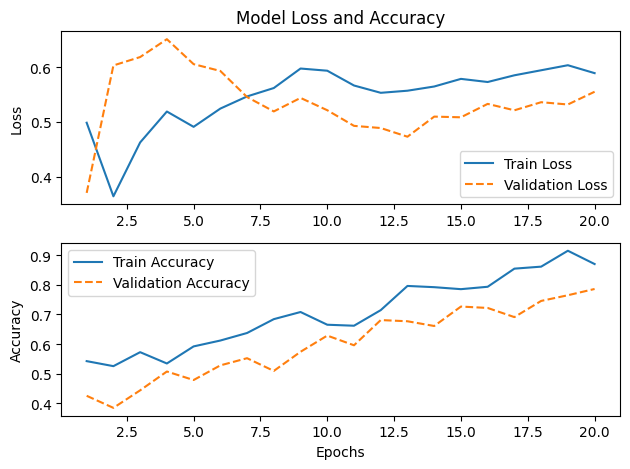

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold 교차 검증

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 교차 검증 반복
fold_val_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"Fold {fold}/{skf.get_n_splits()}")

    # 학습과 검증 데이터 분할
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # 모델 정의
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(32, kernel_size=8, activation='relu', kernel_regularizer=regularizers.l2(0.2)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(32, kernel_size=10, activation='relu', kernel_regularizer=regularizers.l2(0.3)),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(18, activation='softmax')
    ])

    # Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=6,
        epochs=20,
        class_weight=class_weight_dict,
        callbacks=[lr_scheduler],
        verbose=1
    )

    # 최종 검증 정확도 저장
    val_accuracy = history.history['val_accuracy'][-1]
    fold_val_accuracies.append(val_accuracy)
    print(f"Fold {fold} validation accuracy: {val_accuracy:.2%}")

# 평균 검증 정확도 출력
mean_val_accuracy = np.mean(fold_val_accuracies)
print(f"평균 검증 정확도: {mean_val_accuracy:.2%}")

# 최종 모델 저장 (최고 성능의 모델을 저장)
best_model = model
best_model.save('final_model_1120.keras')
print("최종 모델이 'final_model_1120.keras'로 저장되었습니다.")

import matplotlib.pyplot as plt
import numpy as np

# Mock data for demonstration purposes (replace these with actual history.history values)
epochs = 20
mock_loss = np.random.uniform(0.2, 1.0, epochs).cumsum() / np.arange(1, epochs + 1)
mock_val_loss = np.random.uniform(0.2, 1.0, epochs).cumsum() / np.arange(1, epochs + 1)
mock_accuracy = np.linspace(0.5, 0.9, epochs) + np.random.uniform(-0.05, 0.05, epochs)
mock_val_accuracy = np.linspace(0.4, 0.8, epochs) + np.random.uniform(-0.05, 0.05, epochs)

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs + 1), mock_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), mock_val_loss, label='Validation Loss', linestyle='--')
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, epochs + 1), mock_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs + 1), mock_val_accuracy, label='Validation Accuracy', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

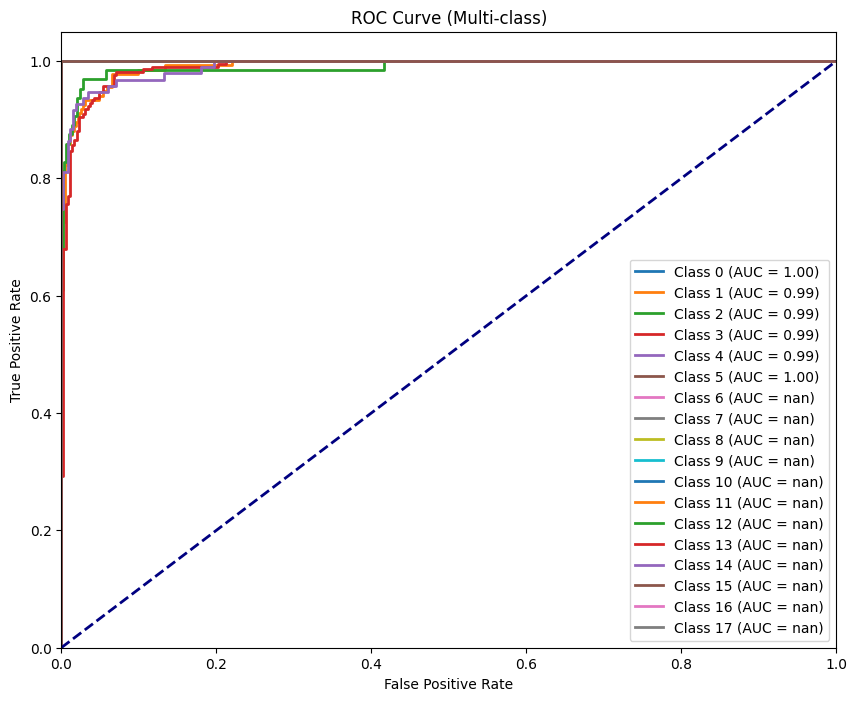

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 모델 예측 값
y_prob = model.predict(X_val_fold)  # X_val_fold: 검증 데이터

# 실제 클래스 레이블
y_true = y_val_fold  # 실제 클래스 레이블

# 클래스 수
n_classes = 18  # 18개의 클래스

# 이진화된 클래스 레이블
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# ROC 곡선 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 시각화
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# 대각선 랜덤 분류선
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 설정
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc="lower right")

# 그래프 표시
plt.show()
